In [174]:
import numpy as np
import pandas as pd
import os
from tkinter import Tk
from tkinter.filedialog import askopenfilename

## First determine the average viscosity of water measured at the start of the experiment

In [175]:
# Open Milli-Q Water Flow Sweep file and obtain the directory and filename

root = Tk()
root.withdraw()
filepath_water = askopenfilename(message="Select the Milli-Q Water Flow Sweep data")
root.update()

filename_water = os.path.basename(filepath_water)
directory_water = filepath_water[0:-len(filename_water)]

# Load the data into a dataframe
df_water = pd.read_csv(filepath_water,header=91)
df_water.rename(columns={'Pa':'stress','1/s':'shear rate','Pa.s':'viscosity','min':'step time','°C':'temperature','Pa.1':'normal stress difference'},inplace=True)

# Determine the number of flow sweep runs performed
breaks = df_water['viscosity'].isnull().sum()
breaks = breaks/2
runs = breaks + 1.0

# Drop the empty rows that separate the different runs in the datafile
df_water=df_water.apply(pd.to_numeric, errors='coerce')
df_water.dropna(axis=0,inplace=True)
df_water.reset_index(inplace=True)

# Organize all of the runs into a dictionary of dataframes
i = len(df_water)/runs
i = i.astype(int)

df_water_dict = {n: df_water.iloc[n:n+i, :] 
           for n in range(0, len(df_water), i)}


# Fit the stress vs strain rate data for water for all of the runs and obtain the average viscosity and its stdev
eta = np.array([])
b = np.array([])

for keys in df_water_dict.keys():
    x = df_water_dict[keys]['shear rate']
    y = df_water_dict[keys]['stress']
    fit = np.polyfit(x,y,deg=1)

    eta = np.append(eta,fit[0])
    b = np.append(b,fit[1])
    
eta_avg = np.mean(eta)
eta_stdev = np.std(eta)
b_avg = np.mean(b)

## Get the PG measurement datafile and read data into a dataframe

In [176]:
root = Tk()
root.withdraw()
filepath_PG = askopenfilename(message="Select the PG measurement data")
root.update()

filename_PG = os.path.basename(filepath_PG)
directory_PG = filepath_PG[0:-len(filename_PG)]


In [177]:
directory_PG

'/Users/hurmizshamana/Desktop/Python Analyzed Data/2021-01-20/'

In [178]:
df_PG = pd.read_csv(filepath_PG,skiprows=91,skipfooter=52,engine='python')
df_PG.rename(columns={'Pa':'stress','1/s':'shear rate','Pa.s':'viscosity','min':'step time','°C':'temperature','Pa.1':'normal stress difference'},inplace=True)

In [179]:
breaks = df_PG['viscosity'].isnull().sum()
breaks = breaks/2
runs = breaks + 1.0

In [180]:
df_PG=df_PG.apply(pd.to_numeric, errors='coerce')
df_PG.dropna(axis=0,inplace=True)
df_PG.reset_index(inplace=True)

In [181]:
i = len(df_PG)/runs
i = i.astype(int)

df_PG_dict = {n: df_PG.iloc[n:n+i, :] 
           for n in range(0, len(df_PG), i)}

# Determine an appropriate initial guess for the Cross model parameters

In [182]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [191]:
# Select the smallest shear rate that falls outside of the noise of the data
min_shear_rate = 2
max_shear_rate = 1000

eta_o = 0.045
k=0.0001
m=0.8
params = [eta_o,k,m]

gamma_dot = np.linspace(min_shear_rate,max_shear_rate,1000)
cross = eta_o/(1 + (k*gamma_dot)**m)

# df_cross = pd.DataFrame({'shear rate':gamma_dot,'initial guess':cross})

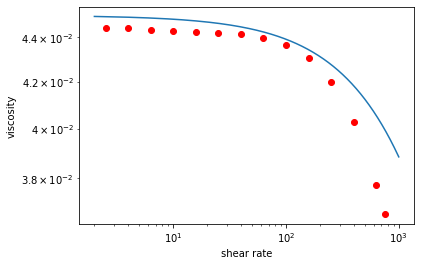

In [192]:
x = df_PG_dict[0][df_PG_dict[0]['shear rate']>=min_shear_rate]['shear rate']
y = df_PG_dict[0][df_PG_dict[0]['shear rate']>=min_shear_rate]['viscosity']

plt.scatter(x,y,color = 'red')
plt.plot(gamma_dot,cross)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('shear rate')
plt.ylabel('viscosity')
plt.show()

# Using the initial guess, fit the data to the Cross model

In [193]:
from scipy.optimize import curve_fit

def func(x,eta_o,k,m):
    return eta_o/(1 + (k*x)**m)

In [194]:
zero_shear_visc = np.array([])
k_array = np.array([])
m_array = np.array([])

for keys in df_PG_dict.keys():
    x = df_PG_dict[keys][df_PG_dict[keys]['shear rate']>=min_shear_rate]['shear rate']
    y = df_PG_dict[keys][df_PG_dict[keys]['shear rate']>=min_shear_rate]['viscosity']
    popt, pcov = curve_fit(func,x,y,p0=params)
    
    zero_shear_visc = np.append(zero_shear_visc,popt[0])
    k_array = np.append(k_array,popt[1])
    m_array = np.append(m_array,popt[2])

In [195]:
# best_fit_cross = zero_shear_visc/(1 + (k_array*gamma_dot)**m_array)

# Plot all of the datasets and their corresponding best fits to the Cross model

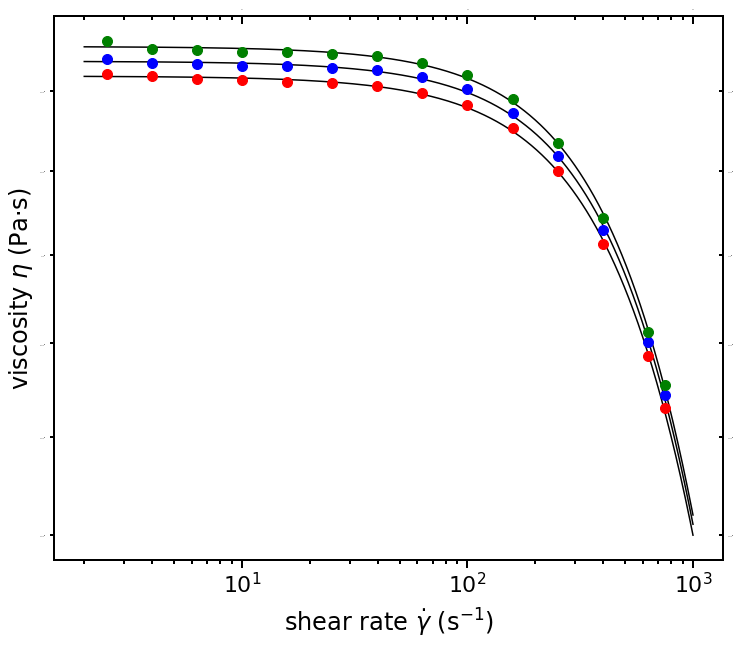

In [196]:
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'w']

ax = df_PG_dict[0][df_PG_dict[0]['shear rate']>=min_shear_rate].plot(kind='scatter',
                                                                    x='shear rate',
                                                                    y='viscosity',
                                                                    s=100,
                                                                    figsize=(12,10),
                                                                    color=colors[0])

plt.plot(gamma_dot,zero_shear_visc[0]/(1 + (k_array[0]*gamma_dot)**m_array[0]),color='black',zorder=0)

for keys in list(df_PG_dict.keys())[1:]:
    
    i = list(df_PG_dict.keys()).index(keys)
    
    df_PG_dict[keys][df_PG_dict[keys]['shear rate']>=min_shear_rate].plot(kind='scatter',
                                                                       x='shear rate',
                                                                       y='viscosity',
                                                                       s=100, 
                                                                       color = colors[i], 
                                                                       ax = ax)
    
    plt.plot(gamma_dot,zero_shear_visc[i]/(1+(k_array[i]*gamma_dot)**m_array[i]),color='black',zorder=0)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r'viscosity $\eta$ (Pa$\cdot$s)',fontsize=24)
ax.set_xlabel(r'shear rate $\dot{\gamma}$ (s$^{-1}$)',fontsize=24,labelpad=10)

ax2 = ax.secondary_yaxis('right')
ax3 = ax.secondary_xaxis('top')


ax.tick_params(axis='both',which='major',length=8, width=2,labelsize=22,direction='out')
ax.tick_params(axis='both',which='minor',length=4, width=2,labelsize=0,direction='out')
ax2.tick_params(axis='both',which='major',length=8, width=2,labelsize=0, direction='in')
ax2.tick_params(axis='both',which='minor',length=4, width=2,labelsize=0, direction='in')
ax3.tick_params(axis='both',which='major',length=8, width=2,labelsize=0, direction='in')
ax3.tick_params(axis='both',which='minor',length=4, width=2,labelsize=0, direction='in')

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax2.spines['right'].set_linewidth(2)
ax3.spines['top'].set_linewidth(2)

# ax.annotate(r'$\eta_{avg}$ = %.6f Pa s' % eta_avg, xy=(10,0.09),fontsize=20)

plt.savefig(directory_PG+filename_PG+' Cross fit.png',facecolor='w')
plt.show()

In [197]:
# figure out how to make input boxes appear to enter the required inputs
# think about the best way to output all of the data (plots,average viscosities + errors, etc)